***SSMIF FALL 2024 CODING CHALLENGE: POLYMARKET***

Thank you for attempting the SSMIF Fall 2024 Coding Challenge! Attached to this challenge will be a pdf with the rules and guidelines for the challenge.  

ADDITIONAL RULES

- As mentioned above, machine learning will only be permitted for Palladium. The rest of the goods should have systematic and statistically backed signals
- Feel free to add additional cells to seperate code as needed
- Clearly comment your code and explain your thought process thoroughly. Utilizing markdowns to further explain your code will also work
-


**Part I: Constructor and Data Cleaning**
With the data provided, please write a clean_data function to remove any inconsistencies in the data. This cleaned data will be the basis of the future parts of the challenge.

Create a constructor that reads in the excel file and calls all necessary methods. You may set the output of these methods to be attributes of the class that you may access later on in other challenges.

In [ ]:
#write your implementations below
import pandas as pd
import re
import numpy as np

valid_columns = set(["Date", "Open", "High", "Low", "Close", "Volume"])

def filter_date_outliers(df: pd.DataFrame, date_column: str) -> pd.DataFrame:
    df[date_column] = pd.to_datetime(df[date_column])
    numeric_dates = df[date_column].astype('int64')
    Q1 = pd.Series(numeric_dates).quantile(0.25)
    Q3 = pd.Series(numeric_dates).quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    mask = (numeric_dates >= lower_bound) & (numeric_dates <= upper_bound)
    return df[mask]

def filter_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    mask = pd.Series(True, index=df.index)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    mask &= (df[column] >= lower_bound) & (df[column] <= upper_bound)
    return df[mask]

def clean_data() -> dict:
  datadict = {}
  for name in ["palladium", "oil", "semiconductor", "bread", "butter"]:
    print(f"\n\n============== {name} ================================\n\n")
    df = pd.read_csv(f"./Main Challenge Data/{name}_training_data.csv", encoding='ISO-8859-1')

    filled = 0
    missing_columns = list(valid_columns - set(df.columns))
    for col in df.columns:
      cleaned = re.sub(r'[^\w\s]', '', col).strip()

      if cleaned in valid_columns:
        df.rename(columns={col:cleaned}, inplace=True)
      elif len(missing_columns) == 1 and filled == 0 and not col.startswith("Unnamed"):
        df.rename(columns={col:missing_columns[0]}, inplace=True)
        filled += 1
      else:
        df.drop(col, axis=1, inplace=True)

    for col in df.columns:
      if df[col].dtype == "object":
        df[col] = df[col].str.replace(r'[^0-9/\.]', '', regex=True).replace(r'\.+', '.', regex=True)
        df[col] = df[col].apply(lambda x: re.sub(r'\.(?=.*\.)', '', x) if isinstance(x, str) else x)

        if col == "Date":
          df[col] = pd.to_datetime(df[col], errors='coerce')
          df = filter_date_outliers(df, col)
        else:
          df[col] = pd.to_numeric(df[col], errors='coerce')
          df = filter_outliers(df, col)
      else:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = filter_outliers(df, col)

    df = df.ffill().bfill()
    df = df.set_index("Date")
    print(df.info())
    display(df.head())
    datadict[name] = df
  return datadict

datadict = clean_data()



============== palladium ================================




FileNotFoundError: [Errno 2] No such file or directory: './Main Challenge Data/palladium_training_data.csv'

**Part II: Signal Creation**
The second part of this challenge will be to create trading signals for the commodities below. Attached to this challenge will be historical data for each of the commodities below. While this should provide a guideline, please note that **the training data provided will NOT be the sole metric of your score**. Your code will be tested on new data and the performance of your strategy with this new data will be heavily factored into your final score.


Hint: The new data that your code will be scored on will not directly represent the training data. The signals you make should be tailored to the provided data but also be dynamic and adaptable to fluctuations in the data

In [ ]:
#Write your implementations below
from typing import List
from datetime import date
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

class Signal:
    def __init__(self, quantity: int):
        self.quantity = quantity

def calculate_rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(series: pd.Series, short_window: int = 12, long_window: int = 26, signal_window: int = 9):
    ema_short = series.ewm(span=short_window, adjust=False).mean()
    ema_long = series.ewm(span=long_window, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

def signal_oil(data: pd.DataFrame, tickers: List[str], day: date, ticker: str) -> Signal:
    df = data.loc[data.index <= day]
    df = df.sort_index()
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = calculate_macd(df['Close'])

    short_window = 10
    long_window = 50
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()

    rsi_latest = df['RSI'].iloc[-1]
    macd_latest = df['MACD'].iloc[-1]
    macd_signal_latest = df['MACD_signal'].iloc[-1]
    sma_short_latest = df['SMA_short'].iloc[-1]
    sma_long_latest = df['SMA_long'].iloc[-1]

    if (rsi_latest > 30 or macd_latest > macd_signal_latest) and sma_short_latest < sma_long_latest:
        return Signal(1)
    elif (rsi_latest < 70 or macd_latest < macd_signal_latest) and sma_short_latest > sma_long_latest:
        return Signal(-1)
    else:
        return Signal(0)



def signal_palladium(data: pd.DataFrame, tickers: List[str], day: date, ticker: str) -> Signal:
    df = data.loc[data.index <= day]
    df = df.sort_index()
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = calculate_macd(df['Close'])

    short_window = 10
    long_window = 50
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()

    rsi_latest = df['RSI'].iloc[-1]
    macd_latest = df['MACD'].iloc[-1]
    macd_signal_latest = df['MACD_signal'].iloc[-1]
    sma_short_latest = df['SMA_short'].iloc[-1]
    sma_long_latest = df['SMA_long'].iloc[-1]

    if (rsi_latest > 30 or macd_latest > macd_signal_latest) and sma_short_latest > sma_long_latest:
        return Signal(1)
    elif (rsi_latest < 70 or macd_latest < macd_signal_latest) and sma_short_latest < sma_long_latest:
        return Signal(-1)
    else:
        return Signal(0)





def signal_semiconductor(data: pd.DataFrame, tickers: List[str], day: date, ticker: str) -> Signal:
    df = data.loc[data.index <= day]
    df = df.sort_index()
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = calculate_macd(df['Close'])

    short_window = 10
    long_window = 50
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()

    rsi_latest = df['RSI'].iloc[-1]
    macd_latest = df['MACD'].iloc[-1]
    macd_signal_latest = df['MACD_signal'].iloc[-1]
    sma_short_latest = df['SMA_short'].iloc[-1]
    sma_long_latest = df['SMA_long'].iloc[-1]

    if (rsi_latest < 30 or macd_latest < macd_signal_latest) and sma_short_latest < sma_long_latest:
        return Signal(1)
    elif (rsi_latest > 70 or macd_latest > macd_signal_latest) and sma_short_latest > sma_long_latest:
        return Signal(-1)
    else:
        return Signal(0)




def signal_bread(data: pd.DataFrame, tickers: List[str], day: date, ticker: str) -> Signal:
    df = data.loc[data.index <= day]
    df = df.sort_index()
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = calculate_macd(df['Close'])

    short_window = 10
    long_window = 50
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()

    rsi_latest = df['RSI'].iloc[-1]
    macd_latest = df['MACD'].iloc[-1]
    macd_signal_latest = df['MACD_signal'].iloc[-1]
    sma_short_latest = df['SMA_short'].iloc[-1]
    sma_long_latest = df['SMA_long'].iloc[-1]

    if (rsi_latest < 30 or macd_latest > macd_signal_latest) and sma_short_latest > sma_long_latest:
        return Signal(1)
    elif (rsi_latest > 70 or macd_latest < macd_signal_latest) and sma_short_latest < sma_long_latest:
        return Signal(-1)
    else:
        return Signal(0)





def signal_butter(data: pd.DataFrame, tickers: List[str], day: date, ticker: str) -> Signal:
    df = data.loc[data.index <= day]
    df = df.sort_index()
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = calculate_macd(df['Close'])

    short_window = 10
    long_window = 50
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()

    rsi_latest = df['RSI'].iloc[-1]
    macd_latest = df['MACD'].iloc[-1]
    macd_signal_latest = df['MACD_signal'].iloc[-1]
    sma_short_latest = df['SMA_short'].iloc[-1]
    sma_long_latest = df['SMA_long'].iloc[-1]

    if (rsi_latest < 20 or macd_latest > macd_signal_latest) and sma_short_latest < sma_long_latest:
        return Signal(1)
    elif (rsi_latest > 60 or macd_latest < macd_signal_latest) and sma_short_latest > sma_long_latest:
        return Signal(-1)
    else:
        return Signal(0)


**Part III: Backtesting and Write Up**

In order to interact with the backtester, the signal function must return a Signal object, as this is how the backtester processes and executes trades based on the signal's quantity—whether it's a buy, sell, or hold decision. You can create as many signal-generating functions as you like, as long as the signal functions given (signal_oil, signal_semiconductors, etc) return a Signal object.

In [ ]:
#### DO NOT CHANGE ANY OF THE CODE FROM THE BACKTESTER. CHANGING CODE FOR THE BACKTESTER WILL RESULT IN AUTOMATIC DISQUALIFICATION ####
import pandas as pd
import yfinance as yf
from datetime import date, datetime, timedelta
from typing import Callable, List
from dataclasses import dataclass
from random import choice
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Callable, Dict, List
import matplotlib.dates as mdates

#### DO NOT CHANGE ANY OF THE CODE FROM THE BACKTESTER. CHANGING CODE FOR THE BACKTESTER WILL RESULT IN AUTOMATIC DISQUALIFICATION ####
class Backtester:
    def __init__(self, tickers, initial_capital=1_000_000):
        self.tickers = tickers
        self.initial_capital = initial_capital
        self.holdings = {
            "cash": initial_capital,
            **{ticker: (0.0, 0, None) for ticker in tickers}  # Each ticker: (avg_price, quantity, timestamp)
        }
        self.transaction_log = []  # Store all executed trades
        self.daily_pl_log = []
        self.ticker_pnl_log = []

    def update_holdings(self, ticker, price, quantity, date):
        """
        Update holdings based on executed orders, managing position averaging and timestamps.
        """
        cash = self.holdings["cash"]
        p, q, last_timestamp = self.holdings[ticker]

        # For BUY
        if quantity > 0:
            total_cost = quantity * price
            if cash >= total_cost:
                self.holdings["cash"] -= total_cost
                new_avg_price = ((p * q) + (price * quantity)) / (q + quantity) if q + quantity != 0 else 0
                self.holdings[ticker] = (new_avg_price, q + quantity, date)
                self.log_transaction(ticker, price, quantity, date)
            else:
                print(f"Insufficient cash to buy {quantity} of {ticker} at {price} on {date}")

        # For SELL
        elif quantity < 0:
            if q >= abs(quantity):
                proceeds = abs(quantity) * price
                self.holdings["cash"] += proceeds
                self.holdings[ticker] = (p, q + quantity, date)
                self.log_transaction(ticker, price, quantity, date)
            else:
                print(f"Insufficient shares to sell {abs(quantity)} of {ticker} on {date}")


    def update_holdings_pairs(self, ticker, price, quantity, date):
        """
        Update holdings based on executed orders, managing position averaging and timestamps.
        """
        cash = self.holdings["cash"]
        p, q, last_timestamp = self.holdings[ticker]

        # For BUY
        if quantity > 0:
            total_cost = quantity * price
            if cash >= total_cost:
                self.holdings["cash"] -= total_cost
                new_avg_price = ((p * q) + (price * quantity)) / (q + quantity) if q + quantity != 0 else 0
                self.holdings[ticker] = (new_avg_price, q + quantity, date)
                self.log_transaction(ticker, price, quantity, date)
            else:
                print(f"Insufficient cash to buy {quantity} of {ticker} at {price} on {date}")

        # For SELL (including short selling)
        elif quantity < 0:
            proceeds = abs(quantity) * price
            potential_cash = self.holdings["cash"] + proceeds

            # Ensure that selling doesn't reduce total holdings value below initial capital
            total_asset_value = self.calculate_total_value(ticker, potential_cash, price, quantity)
            if total_asset_value >= self.initial_capital:
                self.holdings["cash"] += proceeds
                self.holdings[ticker] = (p, q + quantity, date)  # q can become negative (short sell)
                self.log_transaction(ticker, price, quantity, date)
            else:
                print(f"Cannot sell {abs(quantity)} of {ticker} at {price}, would reduce total below capital")

    def calculate_total_value(self, ticker, potential_cash, price, quantity):
        """
        Calculate the total value of the portfolio including holdings and cash.
        """
        total_value = potential_cash
        for t in self.tickers:
            avg_price, q, _ = self.holdings[t]
            if q != 0:
                total_value += q * price  # Add or subtract value of positions
        return total_value



    def execute_signal(self, date, ticker, signal: Signal, data: pd.DataFrame):
        """
        Execute trades based on signals at the close price of the day.
        """
        close_price = data.loc[date, ("Close", ticker)]
        # Handle if close_price is a Series, check if all values are NaN
        if isinstance(close_price, pd.Series):
            if close_price.isna().all():  # If all values in the Series are NaN, skip trading
                return
            close_price = close_price.iloc[0]  # Take the first value if the Series is valid

        # Skip trading if close_price is NaN (after checking for Series)
        if pd.isna(close_price):
            return

        quantity = signal.quantity

        # Don't buy or sell more than limits (cash for buy, shares for sell)
        if quantity > 0:
            max_buyable = self.holdings["cash"] // close_price
            if isinstance(max_buyable, pd.Series):  # Handle possible Series result
                max_buyable = max_buyable.iloc[0]
            quantity = min(quantity, max_buyable)
        elif quantity < 0:
            max_sellable = self.holdings[ticker][1]
            quantity = max(quantity, -max_sellable)

        # Update holdings based on the signal
        self.update_holdings(ticker, close_price, quantity, date)

    def execute_signal_pairs(self, date, ticker, signal: Signal, data: pd.DataFrame):
        """
        Execute trades based on signals at the close price of the day for pairs trading.
        """
        if date not in data.index:
            return  # Skip if date is not in data

        close_price = data.loc[date, 'Close']

        # Skip trading if close_price is NaN
        if pd.isna(close_price):
            return

        quantity = signal.quantity

        # Don't buy more than available cash
        if quantity > 0:
            max_buyable = self.holdings["cash"] // close_price
            quantity = min(quantity, max_buyable)
        # For short selling, no limit on max_sellable

        # Update holdings based on the signal
        if quantity != 0:
            self.update_holdings_pairs(ticker, close_price, quantity, date)



    def run_backtest(self, data: pd.DataFrame, signal_function: Callable[[pd.DataFrame, List[str], date, str], Signal]):
        """
        Main loop to process each date and execute signals.
        """
        dates = data.index
        for date in dates:
            for ticker in self.tickers:
                signal = signal_function(data, self.tickers, date, ticker)
                self.execute_signal(date, ticker, signal, data)
            # At the end of each day, calculate the net P/L
            daily_pl = self.calculate_end_of_day_pl(data, date)
            self.daily_pl_log.append({"date": date, "p/l": daily_pl})

    def run_backtest_pairs(self, data: Dict[str, pd.DataFrame], signal_function: Callable[[Dict[str, pd.DataFrame], List[str], date], Dict[str, Signal]]):
        """
        Main loop to process each date and execute signals for pairs trading.
        """
        # Get the intersection of dates across all tickers
        dates = data[self.tickers[0]].index
        for ticker in self.tickers[1:]:
            dates = dates.intersection(data[ticker].index)
        dates = sorted(dates)

        for date in dates:
            # Get signals for both tickers
            signals = signal_function(data, self.tickers, date)  # User-defined function returns signals for both tickers

            # Execute signals for each ticker
            for ticker in self.tickers:
                self.execute_signal_pairs(date, ticker, signals.get(ticker, Signal(0)), data[ticker])

            # Calculate PnL for combined holdings and per ticker
            total_pl, ticker_pnl = self.calculate_end_of_day_pl_pairs(data, date)
            daily_pl_entry = {"date": date, "total_p/l": total_pl}
            for t in self.tickers:
                daily_pl_entry[f"{t}_p/l"] = ticker_pnl.get(t, 0)
            self.daily_pl_log.append(daily_pl_entry)



    def calculate_end_of_day_pl_pairs(self, data: Dict[str, pd.DataFrame], date):
        """
        Calculate net profit/loss at the end of each trading day using close prices for pairs trading.
        """
        net_value = self.holdings["cash"]
        ticker_pnl = {}

        for ticker in self.tickers:
            avg_price, quantity, last_timestamp = self.holdings[ticker]
            ticker_data = data[ticker]

            if date in ticker_data.index:
                current_close_price = ticker_data.loc[date, 'Close']

                if not pd.isna(current_close_price):
                    position_value = current_close_price * quantity
                    net_value += position_value  # Add the current value of the position

                    # Compute PnL for the ticker
                    pnl = (current_close_price - avg_price) * quantity
                    ticker_pnl[ticker] = pnl
                else:
                    ticker_pnl[ticker] = 0
            else:
                ticker_pnl[ticker] = 0

        # Compute final total value of the portfolio (cash + value of holdings)
        total_value = self.holdings["cash"]
        for ticker in self.tickers:
            avg_price, quantity, _ = self.holdings[ticker]
            if quantity != 0:
                total_value += quantity * data[ticker].loc[date, 'Close']

        # Ensure the total PnL reflects the total portfolio value change
        total_pl = total_value - self.initial_capital

        return total_pl, ticker_pnl  # Return both total PnL and per-ticker PnL



    def calculate_end_of_day_pl(self, data, date):
        """
        Calculate net profit/loss at the end of each trading day using close prices.
        """
        net_value = self.holdings["cash"]

        for ticker in self.tickers:
            avg_price, quantity, last_timestamp = self.holdings[ticker]

            if quantity > 0:
                current_close_price = data.loc[date, ("Close", ticker)]

                # If current_close_price is a Series, check for NaN in the entire Series
                if isinstance(current_close_price, pd.Series):
                    if current_close_price.isna().all():  # Skip if all values are NaN
                        continue
                    current_close_price = current_close_price.iloc[0]  # Take the first value if it's valid

                # Skip if the current close price is NaN (for scalar case)
                if pd.isna(current_close_price):
                    continue

                net_value += current_close_price * quantity

        # Realized profit/loss at the end of the day
        return net_value - self.initial_capital



    def log_transaction(self, ticker, price, quantity, date):
        """
        Log each buy/sell transaction with relevant details.
        """
        transaction_type = "BUY" if quantity > 0 else "SELL"
        self.transaction_log.append({
            "ticker": ticker,
            "price": price,
            "quantity": quantity,
            "date": date,
            "type": transaction_type
        })

    def print_transaction_log(self):
        """
        Display all executed transactions in a formatted table.
        """
        print(f"{'Date':<12} {'Ticker':<8} {'Type':<6} {'Quantity':<10} {'Price':<10}")
        print("-" * 50)

        for transaction in self.transaction_log:
            date = transaction['date']
            ticker = transaction['ticker']
            trans_type = transaction['type']
            quantity = transaction['quantity']
            price = transaction['price']
            print(f"{date:<12} {ticker:<8} {trans_type:<6} {quantity:<10} {price:<10.2f}")


    def print_daily_pl_log(self):
        """
        Display the end-of-day profit/loss log in a formatted table.
        """
        print(f"{'Date':<12} {'End of Day P/L':<15}")
        print("-" * 30)

        for daily_pl in self.daily_pl_log:
            date = daily_pl['date']
            pl = daily_pl['p/l']
            print(f"{date:<12} {pl:<15.2f}")

    def print_daily_pl_log_pairs(self):
        """
        Display the end-of-day profit/loss log in a formatted table for pairs trading.
        """
        headers = ['Date', 'Total P/L'] + [f"{ticker} P/L" for ticker in self.tickers]
        print(' '.join([f"{header:<15}" for header in headers]))
        print("-" * (15 * len(headers)))

        for daily_pl in self.daily_pl_log:
            date = daily_pl['date']
            total_pl = daily_pl['total_p/l']
            date_str = date.strftime('%Y-%m-%d') if isinstance(date, pd.Timestamp) else str(date)
            ticker_pls = [daily_pl.get(f"{ticker}_p/l", 0) for ticker in self.tickers]
            print(f"{date_str:<15} {total_pl:<15.2f}" + ''.join([f"{pl:<15.2f}" for pl in ticker_pls]))

def plot_pnl(backtester, title):
    """
    Function to plot profit and loss (PnL) over time for the given backtester with dual axes.

    Parameters:
    - backtester: Backtester object containing daily PnL log
    - title: Title of the plot to indicate the asset being plotted
    """
    # Extract dates and PnL values from the daily PnL log
    pnl_log = backtester.daily_pl_log
    dates = [entry['date'] for entry in pnl_log]
    daily_pnl = [entry['p/l'] for entry in pnl_log]

    # Compute cumulative PnL
    cumulative_pnl = np.cumsum(daily_pnl)

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot cumulative PnL on the primary y-axis
    ax1.plot(dates, cumulative_pnl, label="Cumulative PnL", color='green', linewidth=2)
    ax1.fill_between(dates, cumulative_pnl, where=(cumulative_pnl >= 0), color='green', alpha=0.1)
    ax1.fill_between(dates, cumulative_pnl, where=(cumulative_pnl < 0), color='red', alpha=0.1)

    # Format the primary y-axis for cumulative PnL
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative PnL ($)', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.grid(True)

    # Create a secondary y-axis for the daily PnL
    ax2 = ax1.twinx()
    ax2.plot(dates, daily_pnl, label="Daily PnL", color='blue', marker='o', linestyle='--', alpha=0.7)
    ax2.set_ylabel('Daily PnL ($)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Title and labels
    plt.title(f'Cumulative and Daily Profit and Loss Over Time - {title}', fontsize=14)

    # Improve layout to avoid overlapping labels
    fig.tight_layout()

    # Show the plot
    plt.show()


def plot_pnl_pairs(backtester, title):
    """
    Function to plot cumulative PnL over time for each ticker in the given backtester.
    """
    # Extract dates and PnL values from the daily PnL log
    pnl_log = backtester.daily_pl_log
    dates = [entry['date'] for entry in pnl_log]
    ticker_daily_pnls = {ticker: [] for ticker in backtester.tickers}
    for entry in pnl_log:
        for ticker in backtester.tickers:
            ticker_daily_pnls[ticker].append(entry.get(f"{ticker}_p/l", 0))

    # Compute cumulative PnL for each ticker
    cumulative_ticker_pnls = {
        ticker: np.cumsum(pnls) for ticker, pnls in ticker_daily_pnls.items()
    }

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Define color palette and line styles
    colors = plt.cm.tab10.colors
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']

    # Plot cumulative PnL for each ticker
    for idx, ticker in enumerate(backtester.tickers):
        cum_pnl = cumulative_ticker_pnls[ticker]
        color = colors[idx % len(colors)]
        line_style = line_styles[idx % len(line_styles)]
        marker = markers[idx % len(markers)]

        ax1.plot(dates, cum_pnl, label=f"Cumulative PnL - {ticker}",
                 color=color, linestyle=line_style, linewidth=2)

    # Plot Total Cumulative PnL
    total_pnl = [entry['total_p/l'] for entry in pnl_log]
    cumulative_total_pnl = np.cumsum(total_pnl)
    ax1.plot(dates, cumulative_total_pnl, label="Total Cumulative PnL", color='black', linewidth=3)

    # Configure primary y-axis
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Cumulative PnL ($)', fontsize=12)
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Create secondary y-axis for daily PnL
    ax2 = ax1.twinx()

    # Plot daily PnL for each ticker as stacked bar chart
    width = np.min(np.diff(mdates.date2num(dates))) * 0.8  # Adjust bar width
    bottom = np.zeros(len(dates))
    for idx, ticker in enumerate(backtester.tickers):
        daily_pnl = ticker_daily_pnls[ticker]
        color = colors[idx % len(colors)]
        ax2.bar(dates, daily_pnl, width=width, bottom=bottom, label=f"Daily PnL - {ticker}", alpha=0.3, color=color)
        bottom += np.array(daily_pnl)

    # Configure secondary y-axis
    ax2.set_ylabel('Daily PnL ($)', fontsize=12)

    # Format x-axis
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.gcf().autofmt_xdate()

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

    plt.title(f'Cumulative and Daily Profit and Loss Over Time - {title}', fontsize=16)
    plt.tight_layout()

    plt.show()

Running backtest for Palladium...
Closing position for palladium by executing -277 units.
            
******************
Final P&L for palladium: $127734.77
            
******************


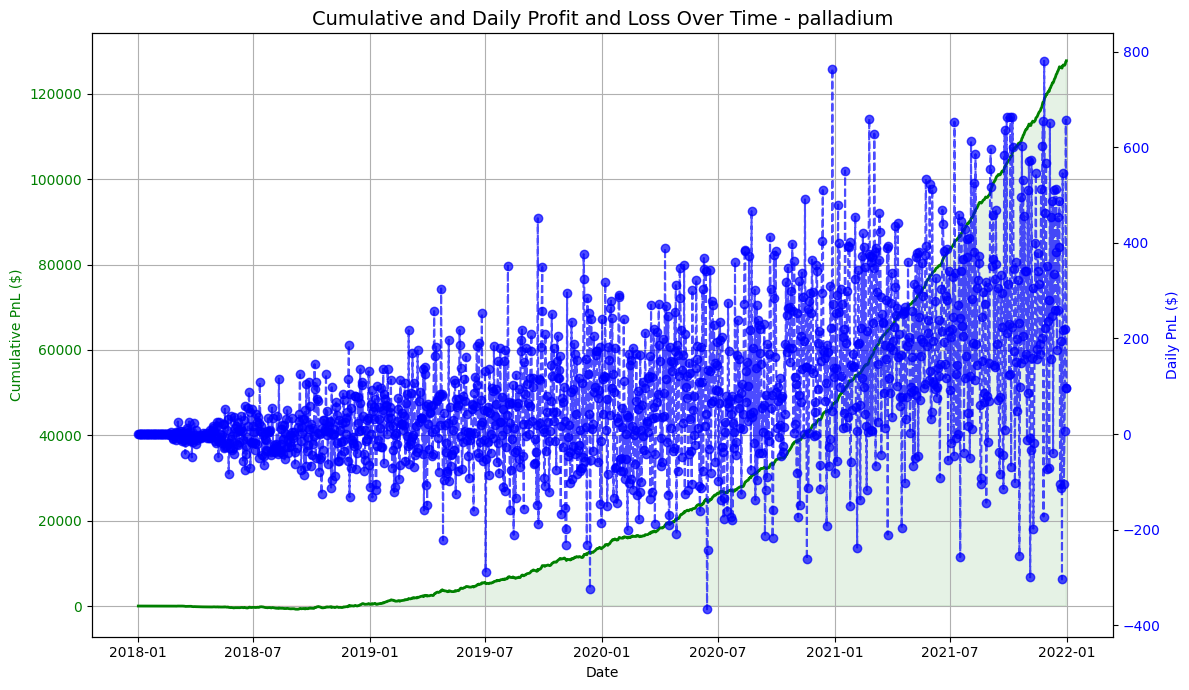

Running backtest for Oil...
Closing position for oil by executing -25 units.
            
******************
Final P&L for oil: $379456.57
            
******************


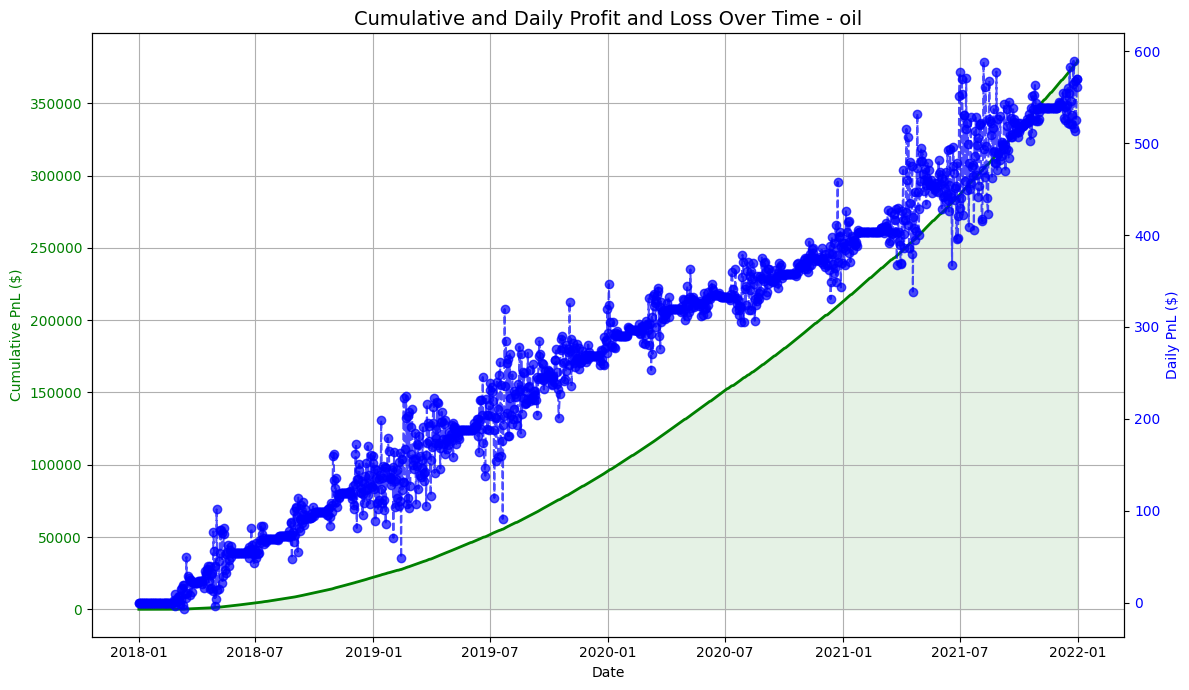

Running backtest for Semiconductor...
Closing position for semiconductor by executing -47 units.
            
******************
Final P&L for semiconductor: $298599.83
            
******************


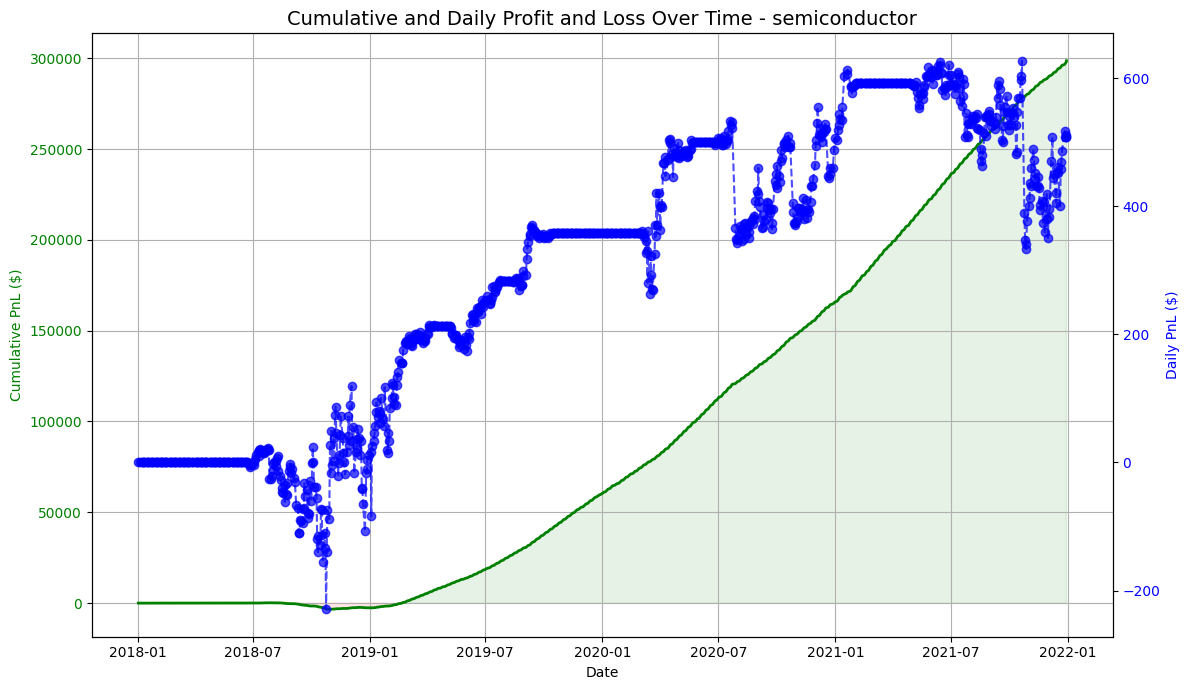

Running backtest for Bread...
Closing position for bread by executing -234 units.
            
******************
Final P&L for bread: $592567.35
            
******************


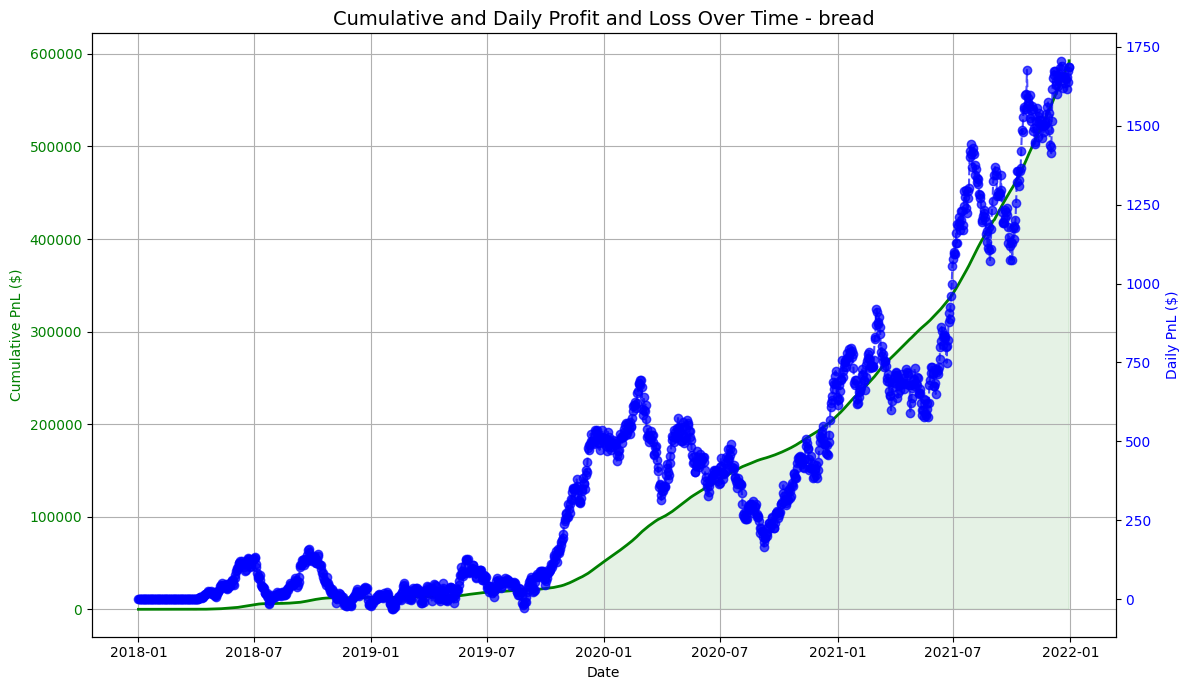

Running backtest for Butter...
Closing position for butter by executing -38 units.
            
******************
Final P&L for butter: $185480.16
            
******************


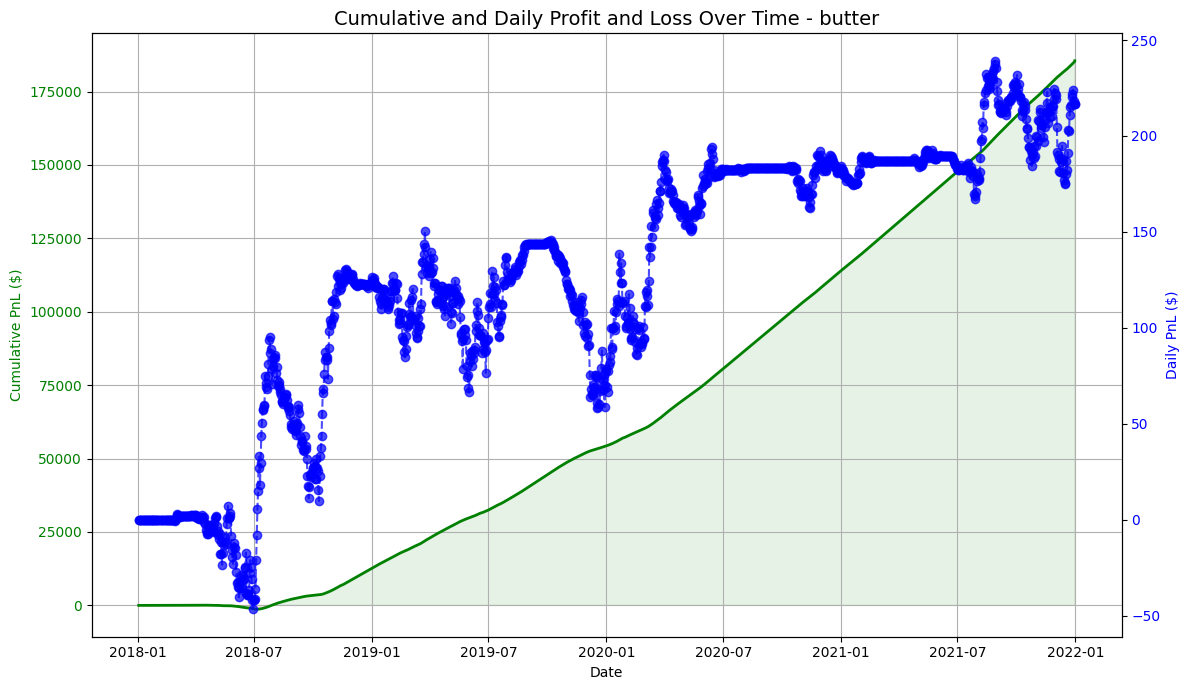

In [ ]:
#write your implementation/paragraph below

# Load data
oil_data = datadict["oil"].copy()
paired_goods_data_bread = datadict["bread"].copy()
paired_goods_data_butter = datadict["butter"].copy()
palladium_data = datadict["palladium"].copy()
semiconductor_data = datadict["semiconductor"].copy()

print_logs = False
plot_chart = True

for name, data0 in datadict.items():
    signal_func = globals()["signal_" + name]
    data = data0.copy()
    data.columns = pd.MultiIndex.from_tuples([(col, name) for col in data.columns])
    backtester = Backtester(tickers=[name])
    print(f"Running backtest for {name.capitalize()}...")
    backtester.run_backtest(data, signal_func)

    # Close positions at the end
    last_date = data.index[-1]
    for ticker in backtester.tickers:
        avg_price, quantity, last_timestamp = backtester.holdings[ticker]
        if quantity != 0:
            close_signal = Signal(-quantity)
            backtester.execute_signal(last_date, ticker, close_signal, data)
            print(f"Closing position for {ticker} by executing {close_signal.quantity} units.")

    # Recalculate final P&L
    daily_pl = backtester.calculate_end_of_day_pl(data, last_date)
    backtester.daily_pl_log.append({"date": last_date, "p/l": daily_pl})
    cumulative_pnl = sum(entry['p/l'] for entry in backtester.daily_pl_log)


    print("            ")
    print('******************')
    print(f"Final P&L for {name}: ${cumulative_pnl:.2f}")
    print("            ")
    print('******************')
    # Print results
    if print_logs:
        backtester.print_transaction_log()
        backtester.print_daily_pl_log()

    if plot_chart:
        plot_pnl(backtester, name)

Each signal implemented in the code serves a distinct purpose, targeting different market conditions and leveraging various technical indicators to generate trading decisions. Signal Oil focuses on identifying potential upward trends by using a combination of the Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD), with specific conditions tied to the short- and long-term Simple Moving Averages (SMAs). It generates buy and sell signals based on whether the RSI exceeds or falls below specific thresholds while also considering the MACD's position relative to its signal line, thus aiming to capture momentum shifts in oil-related investments. On the other hand, Signal Palladium employs a similar framework but emphasizes a bullish SMA relationship, generating signals based on different conditions, which allows it to identify upward momentum more assertively in palladium assets.

Signal Semiconductor adopts a more aggressive strategy, focusing on extreme oversold conditions to identify potential reversals, while Signal Bread combines momentum and trend-following elements, reacting to the market's strength after periods of weakness. Lastly, Signal Butter distinguishes itself by targeting extreme conditions with lower RSI thresholds, aiming to capitalize on potential rebounds from significant price drops. This diversity in approach among the signals allows for a comprehensive trading strategy, enabling traders to navigate varying market dynamics effectively and make informed decisions based on specific asset characteristics. Each signal's unique parameters and logic cater to different trading philosophies, from conservative trend-following to aggressive contrarian plays.